In [1]:
!nvidia-smi

Tue Mar 15 16:48:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install datasets transformers

In [3]:
!wget -O train_en.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
!wget -O test_en.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/test_en.jsonl.bz2

!bzip2 -dk train_en.jsonl.bz2
!bzip2 -dk test_en.jsonl.bz2

!ls -l

--2022-03-15 16:48:44--  https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_en.jsonl.bz2 [following]
--2022-03-15 16:48:45--  https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_en.jsonl.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21191431 (20M) [application/octet-stream]
Saving to: ‘train_en.jsonl.bz2’

train_en.jsonl.bz2  100%[===================>]  20.21M  --.-KB/s    in 0.09s   

2022-03-15 16:48:46 (222 MB/s) - ‘train_en.jsonl.bz

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

output_dir = "./results"
#output_dir = "./drive/MyDrive/utu/kandi/results1"
checkpoint_dir = None # "./results/checkpoint-15000"
tokenizer_name = "bert-base-uncased"
labels = ["label_identity_attack", "label_insult", "label_obscene", "label_severe_toxicity", "label_threat", "label_toxicity"]

device

'cuda:0'

In [5]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

os.environ['WANDB_API_KEY'] = secret_value_0

In [6]:
import numpy as np
from datasets import load_dataset, Dataset

dataset = load_dataset('json', data_files={'train': 'train_en.jsonl', 'test': 'test_en.jsonl'})

  0%|          | 0/2 [00:00<?, ?it/s]

{'id': ['cf295fa7670315a8', 'c359d5b7b912cdad', '4e6bdb1aecf76fa1', '35fbb52ba6078947', '18c27a74d1717da1'], 'label_identity_attack': [0, 0, 0, 0, 0], 'label_insult': [0, 0, 0, 0, 0], 'label_obscene': [0, 0, 0, 0, 0], 'label_severe_toxicity': [0, 0, 0, 0, 0], 'label_threat': [0, 0, 0, 0, 0], 'label_toxicity': [0, 0, 0, 1, 0], 'lang': ['en-orig', 'en-orig', 'en-orig', 'en-orig', 'en-orig'], 'text': ['Do sometimes even you get amazed by what gets put in Wikipedia?\nAs a frequent editor I am sure that you see the whole gambit of odd wiki edits, but that', "I don't mean the Infobox, I mean the Template near the bottom of the article.", 'REDIRECT Talk:Brooks, Kentucky derailment', 'Your contribution to anal sex \n\nI noticed the picture at the top of the article and of course removed it. Since the practice is democratically spread across populations with different orientations, the  homosexualization of the article is gratuitously provocative and possibly worse.', "Where did you hear that t

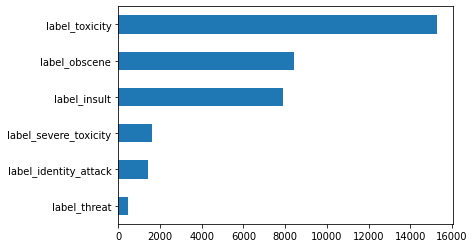

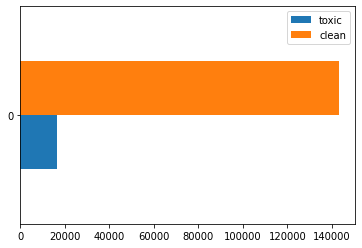

In [7]:
import pandas as pd

df_pandas = pd.DataFrame(dataset['train'])
df_pandas[labels].sum().sort_values().plot(kind="barh");

train_toxic = df_pandas[df_pandas[labels].sum(axis=1) > 0]
train_clean = df_pandas[df_pandas[labels].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');


#train_df = pd.concat([
#  train_toxic,
#  train_clean.sample(40_000, random_state=123)
#])

# shuffle
#dataset['train'] = Dataset.from_pandas(train_df.sample(frac=1, random_state=123))

print(dataset['train'][:5])
print(dataset)

In [8]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

def preprocess(items):
    return tokenizer(items["text"], truncation=True)

ds = dataset.remove_columns(["id", "lang"])
ds = ds.map(lambda it: {'labels': torch.FloatTensor([it[label] for label in labels])})
ds = ds.remove_columns(labels)
tokenized_data = ds.map(preprocess, batched=True)

0ex [00:00, ?ex/s]

  0%|          | 0/57 [00:00<?, ?ba/s]

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [10]:
tokenized_data['train'][0]

{'text': 'Do sometimes even you get amazed by what gets put in Wikipedia?\nAs a frequent editor I am sure that you see the whole gambit of odd wiki edits, but that',
 '__index_level_0__': 26067,
 'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'input_ids': [101,
  2079,
  2823,
  2130,
  2017,
  2131,
  15261,
  2011,
  2054,
  4152,
  2404,
  1999,
  16948,
  1029,
  2004,
  1037,
  6976,
  3559,
  1045,
  2572,
  2469,
  2008,
  2017,
  2156,
  1996,
  2878,
  11721,
  28878,
  1997,
  5976,
  15536,
  3211,
  10086,
  2015,
  1010,
  2021,
  2008,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback

model = None
if checkpoint_dir is not None:
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)
else:
  model = AutoModelForSequenceClassification.from_pretrained(
                                                           tokenizer_name,
                                                           num_labels=len(labels),
                                                           problem_type="multi_label_classification",
                                                           id2label={int(i): v for i, v in enumerate(labels)},
                                                           label2id={str(v): i for i, v in enumerate(labels)},
                                                          )
# model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
!zip -r ./checkpoint.zip ./results/checkpoint-12000
#
#from google.colab import files
#files.download("./checkpoint-4500.zip")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: results/checkpoint-12000/ (stored 0%)
  adding: results/checkpoint-12000/rng_state.pth (deflated 27%)
  adding: results/checkpoint-12000/tokenizer_config.json (deflated 39%)
  adding: results/checkpoint-12000/tokenizer.json (deflated 59%)
  adding: results/checkpoint-12000/config.json (deflated 56%)
  adding: results/checkpoint-12000/scheduler.pt (deflated 49%)
  adding: results/checkpoint-12000/training_args.bin (deflated 48%)
  adding: results/checkpoint-12000/optimizer.pt (deflated 13%)
  adding: results/checkpoint-12000/vocab.txt (deflated 53%)
  adding: results/checkpoint-12000/special_tokens_map.json (deflated 40%)
  adding: results/checkpoint-12000/tr

In [12]:
tokenized_data["train"][:10]['labels']

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [15]:
!ls -alh

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 1.3G
drwxr-xr-x 4 root root 4.0K Mar 15 18:51 .
drwxr-xr-x 5 root root 4.0K Mar 15 15:54 ..
---------- 1 root root  263 Mar 15 15:54 __notebook_source__.ipynb
-rw-r--r-- 1 root root 1.1G Mar 15 18:51 checkpoint.zip
drwxr-xr-x 7 root root 4.0K Mar 15 18:42 results
-rw-r--r-- 1 root root  36M Mar 15 15:56 test_en.jsonl
-rw-r--r-- 1 root root 8.1M Mar 15 16:48 test_en.jsonl.bz2
-rw-r--r-- 1 root root  91M Mar 15 15:56 train_en.jsonl
-rw-r--r-- 1 root root  21M Mar 15 16:48 train_en.jsonl.bz2
drwxr-xr-x 5 root root 4.0K Mar 15 16:49 wandb
